# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

# Helpers

# Carregamento dos dados e EDA inicial

## Carregamento dos dados e análise básica inicial das colunas

In [3]:
df = pd.read_csv("../datasets/Tweets.csv")
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [4]:
df["sentiment"].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [5]:
df["target"] = df["sentiment"].replace({"neutral": 0, "positive": 0, "negative": 1})

/var/folders/hq/v6x2m9xs25x3zvdpyk8mp4y40000gn/T/ipykernel_44285/791106813.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["target"] = df["sentiment"].replace({"neutral": 0, "positive": 0, "negative": 1})


In [6]:
df.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  target  
0  I`d have responded, if I were going   neutral       0  
1                             Sooo SAD  negative       1  
2                          bullying me  negative       1  
3                       leave me alone  negative       1  
4                        Sons of ****,  negative       1

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
 4   target         27481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [8]:
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
target           0
dtype: int64

In [9]:
print("Linhas duplicadas:", df.duplicated().sum())
df[df.duplicated()]

Linhas duplicadas: 0


Empty DataFrame
Columns: [textID, text, selected_text, sentiment, target]
Index: []

In [10]:
df = df.dropna()

## Histograma do número de caracteres

In [11]:
df["char_count"] = df["text"].apply(len)

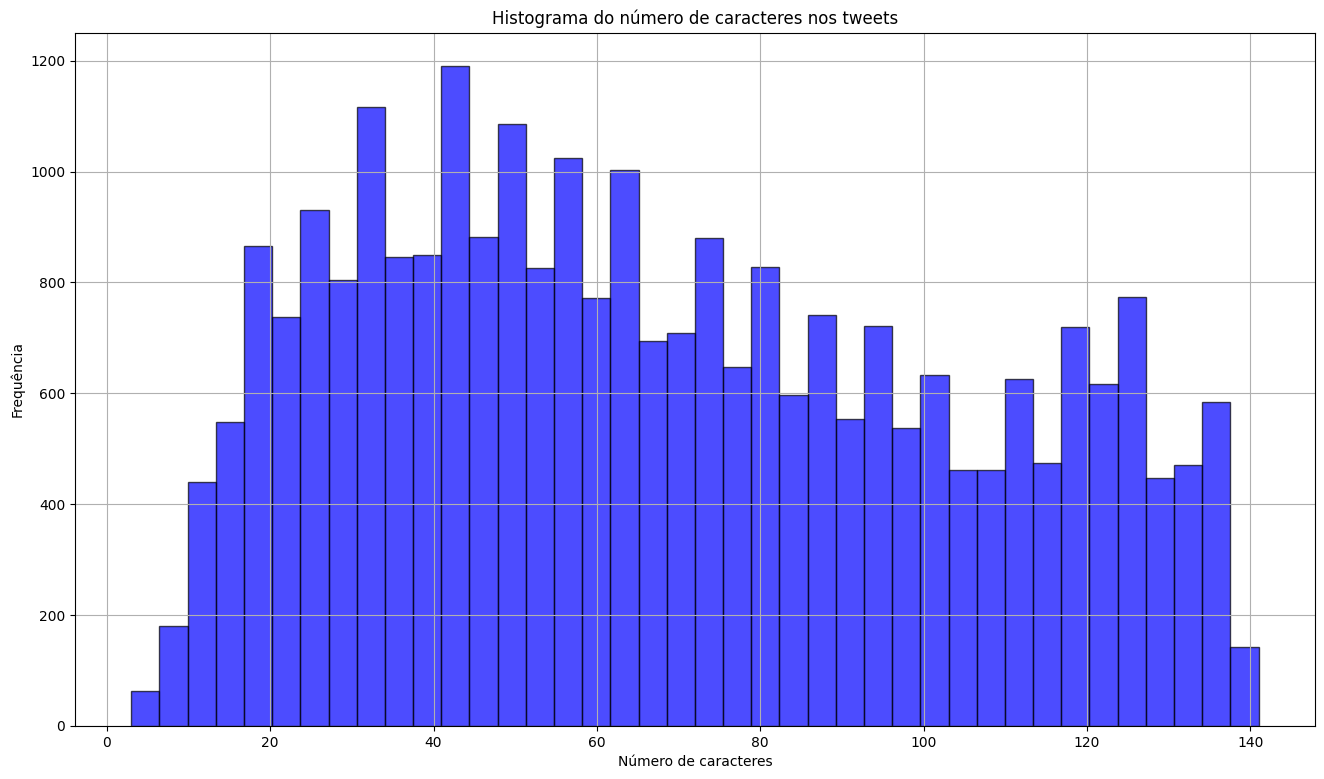

In [12]:
plt.figure(figsize=(16, 9))
df['char_count'].plot(kind='hist', bins=40, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma do número de caracteres nos tweets')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## Histograma do número de palavras

In [13]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

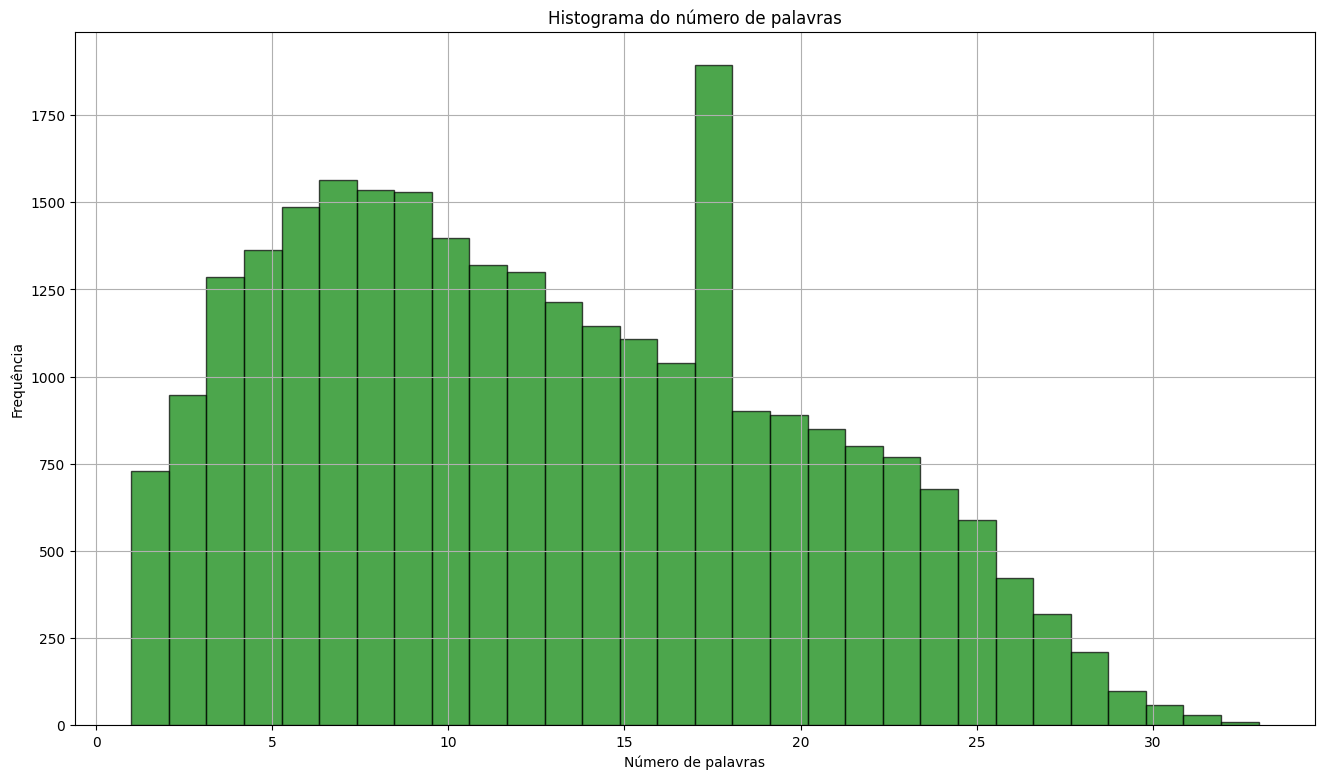

In [14]:
plt.figure(figsize=(16, 9))
df['word_count'].plot(kind='hist', bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Histograma do número de palavras')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

## 5 maiores comentários

In [15]:
top_5_biggest_tweets = df.nlargest(5, "word_count")

In [16]:
for tweet in top_5_biggest_tweets["text"]:
    print(tweet)
    print()

AK, flop comes 2K6 I bet 15 get raised to 25 I call, turn is A, we check, river rag, then I check and he bets 15, I raise 15 he calls, 22

: Lol it went okay! As far as I can tell . But then I had to do a test today for geo and I was all zoned out and got like 65%

How I wish I get at least 2 days-off in a row. 1 day off is not enough to rest.  3 days on, 1 day off, 4 days on, 1 day off...Ugh!!!

My car is in the car hospital for the nxt 7 days  I gotta go pick up a loaner car b4 6! Bein without wheels 4 7day will set me back heavy!

First Happy Mothers Day  Second what is it that makes us think the way we do? Why do we feel the way we feel? I dont know but i wish i did



## 5 menores comentários

In [17]:
top_5_smallest_tweets = df.nsmallest(5, "word_count")

In [18]:
for tweet in top_5_smallest_tweets["text"]:
    print(tweet)
    print()

MAYDAY?!

Chilliin

 Absolutely

_nesmith

 Thx



## Wordcloud

In [19]:
def show_wordcloud(words: str) -> None:
    """Print the word cloud for a given text."""
    wordcloud = WordCloud(background_color="white").generate(words)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### Todos os twwets

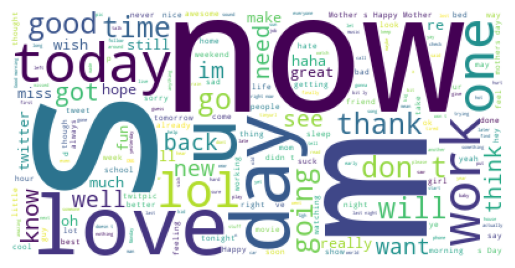

In [20]:
show_wordcloud(" ".join(tweet for tweet in df.text))

### Tweets negativos

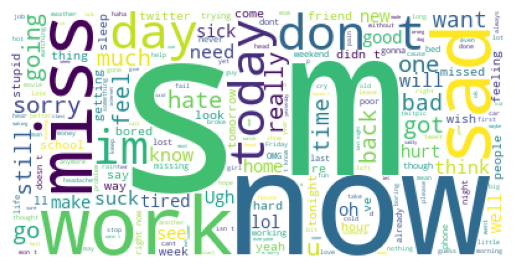

In [21]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "negative"].text))

### Tweets neutros

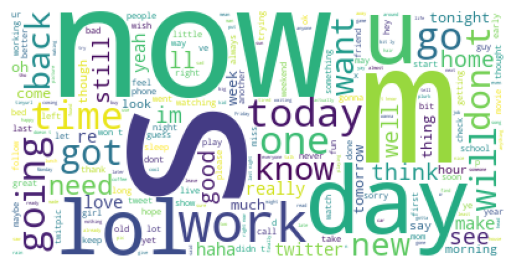

In [22]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "neutral"].text))

### Tweets positivos

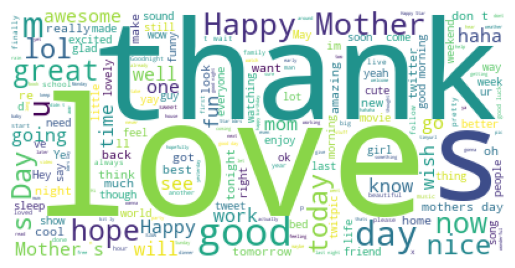

In [23]:
show_wordcloud(" ".join(tweet for tweet in df[df["sentiment"] == "positive"].text))

## Distribuição da variável alvo

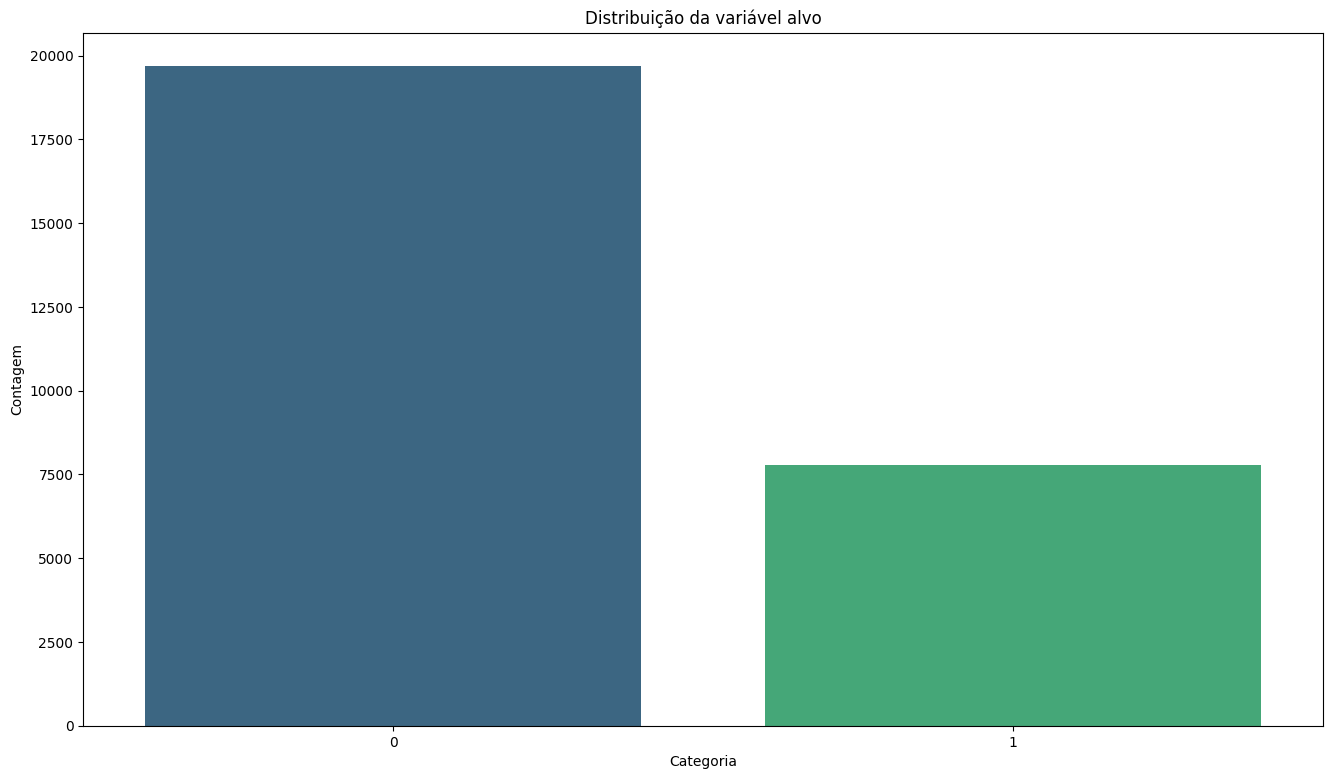

In [24]:
plt.figure(figsize=(16, 9))
sns.countplot(x="target", data=df, hue="target", legend=False, palette="viridis")
plt.title("Distribuição da variável alvo")
plt.xlabel("Categoria")
plt.ylabel("Contagem")
plt.show()

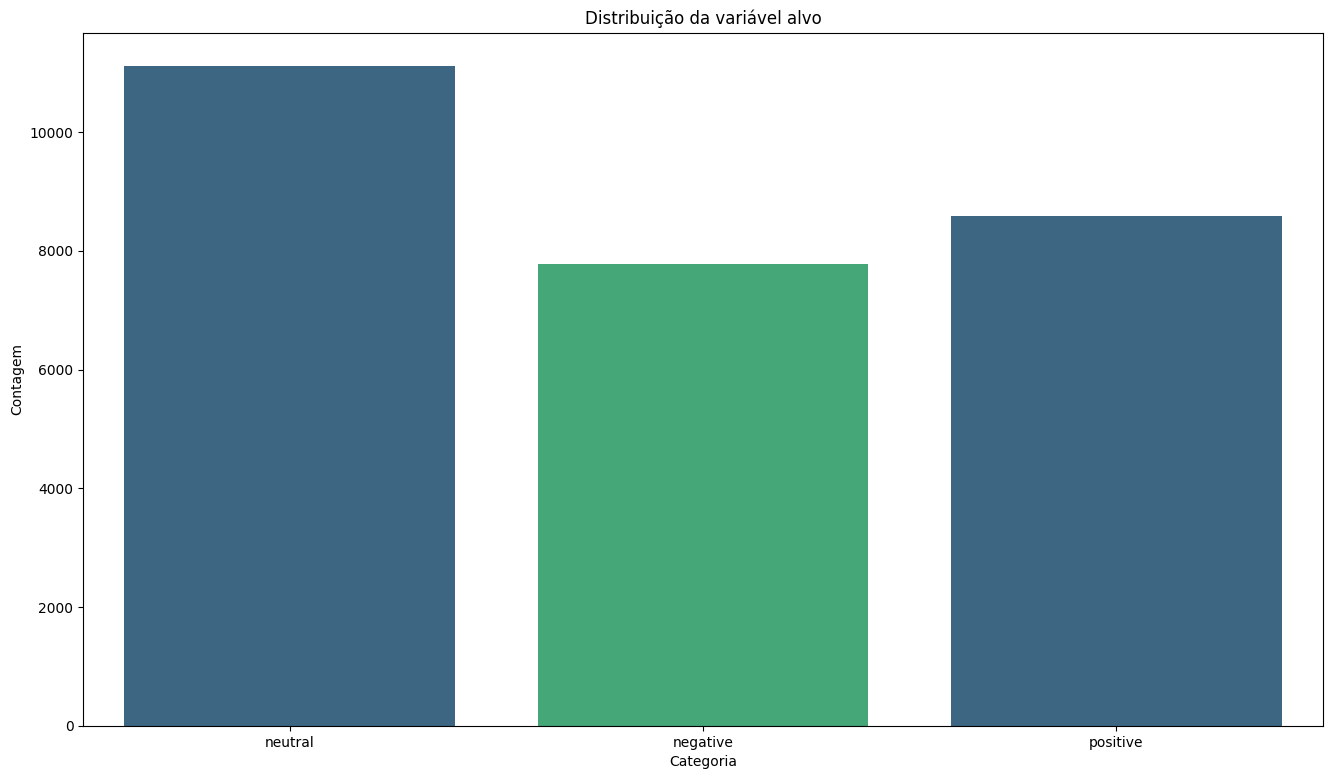

In [25]:
plt.figure(figsize=(16, 9))
sns.countplot(x="sentiment", data=df, hue="target", legend=False, palette="viridis")
plt.title("Distribuição da variável alvo")
plt.xlabel("Categoria")
plt.ylabel("Contagem")
plt.show()

# Limpeza e separação dos dados

## Limpeza

In [26]:
df = df.drop(columns=["textID", "selected_text", "sentiment", "char_count", "word_count"])

In [27]:
df.head()

text  target
0                I`d have responded, if I were going       0
1      Sooo SAD I will miss you here in San Diego!!!       1
2                          my boss is bullying me...       1
3                     what interview! leave me alone       1
4   Sons of ****, why couldn`t they put them on t...       1

In [28]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [29]:
print("Linhas duplicadas:", df.duplicated().sum())
df[df.duplicated()]

Linhas duplicadas: 0


Empty DataFrame
Columns: [text, target]
Index: []

Sem necessidade de tratar dados faltantes (tratado anteriormente) e dados duplicados

## Split

In [30]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['text'],
    df['target'],
    test_size=0.2,
    stratify=df['target'],
    random_state=42
)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  # 25% of 80% is 20% of the total data
    stratify=y_train_val,
    random_state=42
)

No caso, utilizarei validação hold-out.

# Seleção de hiperparâmetros

In [32]:
preprocessing_pipeline = Pipeline([
    ("vectorizer", CountVectorizer())
])

In [33]:
balanced_accuracy = make_scorer(balanced_accuracy_score)

In [34]:
split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))
ps = PredefinedSplit(test_fold=split_index)

## Regressão Logística

In [149]:
pipeline_lr = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("classifier", LogisticRegression(max_iter=1000))
])
param_grid_lr = {
    "classifier__C": [1e-1, 1, 1e2],
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

In [150]:
grid_search_lr.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END ..................................classifier__C=0.1; total time=   0.2s
[CV] END ....................................classifier__C=1; total time=   0.3s
[CV] END ................................classifier__C=100.0; total time=   0.4s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('vectorizer',
                                                         CountVectorizer())])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=8, param_grid={'classifier__C': [0.1, 1, 100.0]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [151]:
print("Melhores parâmetros (LR):", grid_search_lr.best_params_)
print("Melhor score (LR):", grid_search_lr.best_score_)

Melhores parâmetros (LR): {'classifier__C': 1}
Melhor score (LR): 0.7453316456356922


### Teste adicional mudando parâmetros no CountVectorizer

Como eu achei o desempenho relativamente baixo, decidi testar algumas mudanças no CountVectorizer para ver se o desempenho melhora.

In [152]:
pipeline_lr_cv = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", LogisticRegression(max_iter=1000))
])
param_grid_lr_cv = {
    "preprocessing__max_df": (0.5, 0.75, 1.0),
    "preprocessing__ngram_range": [(1, 1), (1, 2)],
    "classifier__C": [1e-1, 1, 1e2],
}
grid_search_lr_cv = GridSearchCV(pipeline_lr_cv, param_grid_lr_cv, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

grid_search_lr_cv.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV] END classifier__C=0.1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 1); total time=   0.2s
[CV] END classifier__C=0.1, preprocessing__max_df=1.0, preprocessing__ngram_range=(1, 1); total time=   0.2s
[CV] END classifier__C=0.1, preprocessing__max_df=0.75, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=0.1, preprocessing__max_df=1.0, preprocessing__ngram_range=(1, 2); total time=   0.8s
[CV] END classifier__C=0.1, preprocessing__max_df=0.5, preprocessing__ngram_range=(1, 2); total time=   0.8s
[CV] END classifier__C=0.1, preprocessing__max_df=0.75, preprocessing__ngram_range=(1, 2); total time=   0.8s
[CV] END classifier__C=1, preprocessing__max_df=1.0, preprocessing__ngram_range=(1, 1); total time=   0.3s
[CV] END classifier__C=1, preprocessing__max_df=0.75, preprocessing__

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=8,
             param_grid={'classifier__C': [0.1, 1, 100.0],
                         'preprocessing__max_df': (0.5, 0.75, 1.0),
                         'preprocessing__ngram_range': [(1, 1), (1, 2)]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [153]:
print("Melhores parâmetros (LR + Custom CV):", grid_search_lr_cv.best_params_)
print("Melhor score (LR + Custom CV):", grid_search_lr_cv.best_score_)

Melhores parâmetros (LR + Custom CV): {'classifier__C': 100.0, 'preprocessing__max_df': 0.5, 'preprocessing__ngram_range': (1, 2)}
Melhor score (LR + Custom CV): 0.749134185011679


Apesar de baixa, **houve** melhoria no score de validação

## SVM com kernel RBF

In [39]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": 10.0**np.arange(-1, 3.01, 1),
    "classifier__gamma": 10.0**np.arange(-1, 3.01, 1)
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

In [40]:
grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ...........classifier__C=0.1, classifier__gamma=0.1; total time=  41.2s
[CV] END ...........classifier__C=1.0, classifier__gamma=0.1; total time=  59.3s
[CV] END ...........classifier__C=0.1, classifier__gamma=1.0; total time= 1.1min
[CV] END .........classifier__C=0.1, classifier__gamma=100.0; total time= 1.3min


/Users/matheushent/Library/Mobile Documents/com~apple~CloudDocs/UFSC/EEL7514/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..........classifier__C=0.1, classifier__gamma=10.0; total time= 1.3min
[CV] END ........classifier__C=0.1, classifier__gamma=1000.0; total time= 1.3min
[CV] END ...........classifier__C=1.0, classifier__gamma=1.0; total time= 1.4min
[CV] END ..........classifier__C=1.0, classifier__gamma=10.0; total time= 1.6min
[CV] END .........classifier__C=1.0, classifier__gamma=100.0; total time= 1.5min
[CV] END ..........classifier__C=10.0, classifier__gamma=0.1; total time= 1.3min
[CV] END ........classifier__C=1.0, classifier__gamma=1000.0; total time= 1.5min
[CV] END .........classifier__C=100.0, classifier__gamma=0.1; total time= 1.3min
[CV] END ........classifier__C=10.0, classifier__gamma=100.0; total time= 2.1min
[CV] END ..........classifier__C=10.0, classifier__gamma=1.0; total time= 2.1min
[CV] END .........classifier__C=10.0, classifier__gamma=10.0; total time= 2.1min
[CV] END .......classifier__C=10.0, classifier__gamma=1000.0; total time= 2.4min
[CV] END .........classifier

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=8,
             param_grid={'classifier__C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'classifier__gamma': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [154]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 10.0, 'classifier__gamma': 0.1}
Melhor score (SVM + kernel RBF): 0.7184010152284264


#### Print bônus dos meus processadores trabalhando bastante

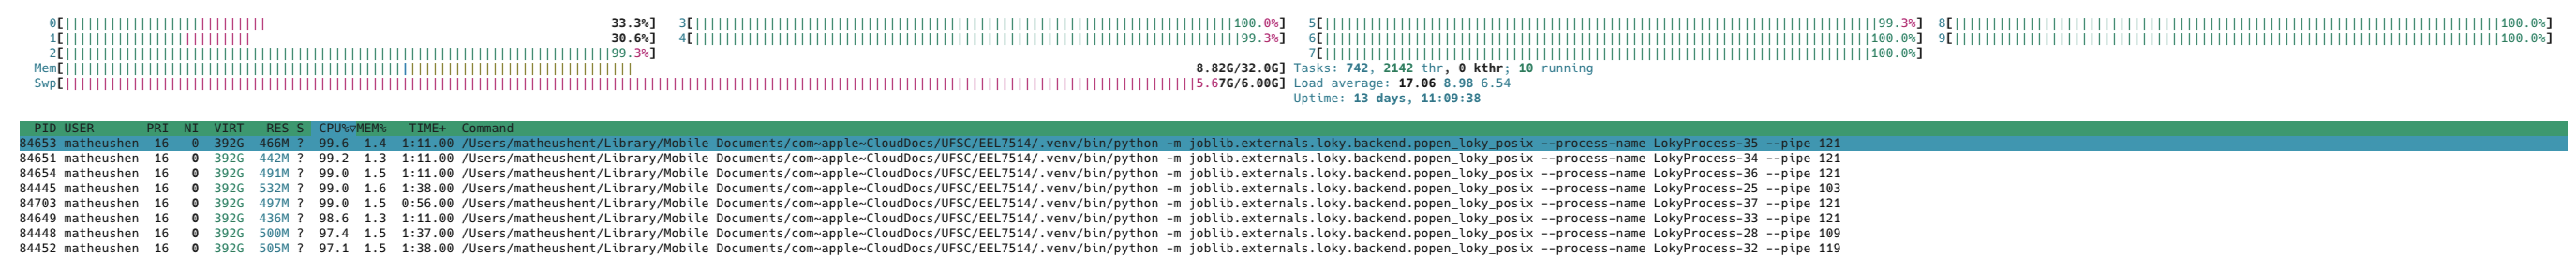

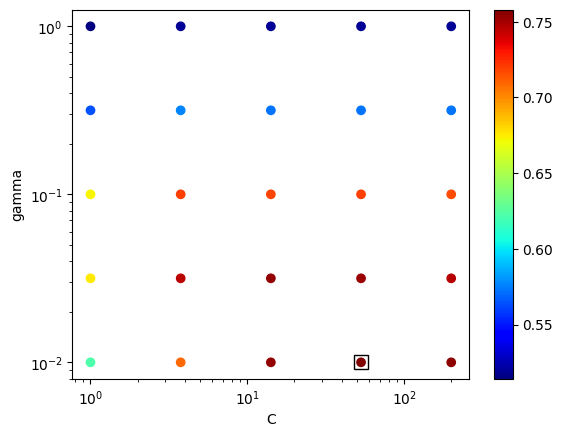

In [46]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Busca mais fina em torno do ponto 1e1 x 1e-1

In [43]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": np.geomspace(1, 200, 5),
    "classifier__gamma": np.geomspace(1e-2, 1, 5),
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=8, verbose=2, cv=ps)

grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ..........classifier__C=1.0, classifier__gamma=0.01; total time=  18.2s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.01; total time=  18.6s
[CV] END classifier__C=1.0, classifier__gamma=0.03162277660168379; total time=  24.9s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.03162277660168379; total time=  53.8s
[CV] END ...........classifier__C=1.0, classifier__gamma=0.1; total time=  55.1s
[CV] END classifier__C=1.0, classifier__gamma=0.31622776601683794; total time= 1.0min
[CV] END classifier__C=14.142135623730951, classifier__gamma=0.01; total time=  42.6s
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.1; total time= 1.2min
[CV] END ...........classifier__C=1.0, classifier__gamma=1.0; total time= 1.2min
[CV] END classifier__C=3.760603093086394, classifier__gamma=0.31622776601683794; total time= 1.4min
[CV] END classifier__C=14.142135623730951, classifier__gamma=0.031622

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=8,
             param_grid={'classifier__C': array([  1.        ,   3.76060309,  14.14213562,  53.18295897,
       200.        ]),
                         'classifier__gamma': array([0.01      , 0.03162278, 0.1       , 0.31622777, 1.        ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [156]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 53.18295896944989, 'classifier__gamma': 0.01}
Melhor score (SVM + kernel RBF): 0.7579244581316144


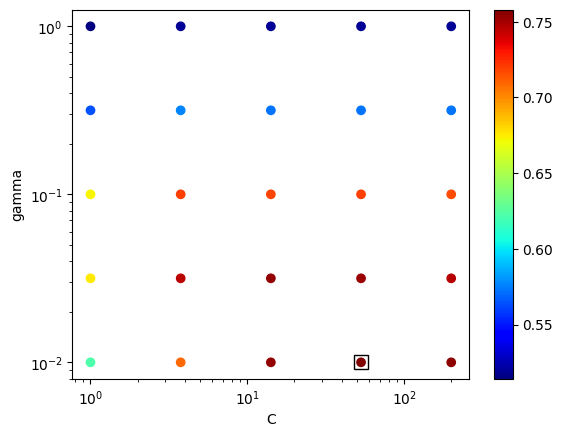

In [45]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Outra busca mais fina

In [50]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", SVC(kernel="rbf"))
])
param_grid_svm = {
    "classifier__C": np.geomspace(30, 50, 5),
    "classifier__gamma": np.geomspace(1e-3, 1e-1, 5),
}
grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, scoring=balanced_accuracy, n_jobs=5, verbose=2, cv=ps)

grid_search_svm.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] END ........classifier__C=30.0, classifier__gamma=0.001; total time=  16.3s
[CV] END classifier__C=30.0, classifier__gamma=0.0031622776601683794; total time=  26.4s
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.001; total time=  16.4s
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.0031622776601683794; total time=  28.5s
[CV] END .........classifier__C=30.0, classifier__gamma=0.01; total time=  55.5s
[CV] END ..........classifier__C=30.0, classifier__gamma=0.1; total time= 1.2min
[CV] END classifier__C=30.0, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=34.08658099402497, classifier__gamma=0.01; total time=  57.0s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.001; total time=  17.2s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.0031622776601683794; total time=  29.9s
[CV] END classifier__C=34.08658099402497, classifier__gam

/Users/matheushent/Library/Mobile Documents/com~apple~CloudDocs/UFSC/EEL7514/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__C=44.00558683966967, classifier__gamma=0.0031622776601683794; total time=  30.4s
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=38.729833462074176, classifier__gamma=0.1; total time= 1.2min
[CV] END ........classifier__C=50.0, classifier__gamma=0.001; total time=  17.3s
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.01; total time= 1.0min
[CV] END classifier__C=50.0, classifier__gamma=0.0031622776601683794; total time=  35.5s
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.03162277660168379; total time= 1.2min
[CV] END classifier__C=44.00558683966967, classifier__gamma=0.1; total time= 1.2min
[CV] END .........classifier__C=50.0, classifier__gamma=0.01; total time= 1.1min
[CV] END classifier__C=50.0, classifier__gamma=0.03162277660168379; total time= 1.1min
[CV] END ..........classifier__C=50.0, classifier__gamma=0.1; total time= 1.1min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier', SVC())]),
             n_jobs=5,
             param_grid={'classifier__C': array([30.        , 34.08658099, 38.72983346, 44.00558684, 50.        ]),
                         'classifier__gamma': array([0.001     , 0.00316228, 0.01      , 0.03162278, 0.1       ])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [158]:
print("Melhores parâmetros (SVM + kernel RBF):", grid_search_svm.best_params_)
print("Melhor score (SVM + kernel RBF):", grid_search_svm.best_score_)

Melhores parâmetros (SVM + kernel RBF): {'classifier__C': 38.729833462074176, 'classifier__gamma': 0.01}
Melhor score (SVM + kernel RBF): 0.7591014967442224


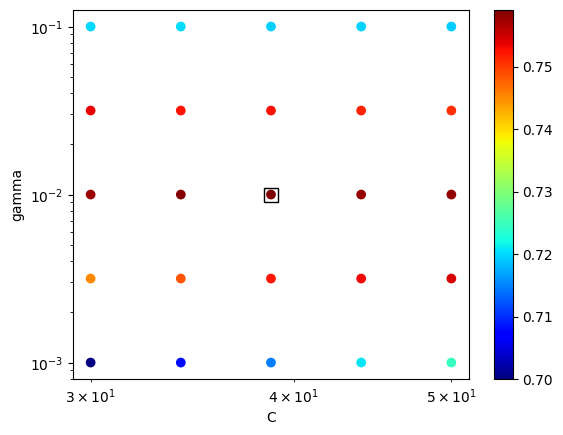

In [52]:
plt.scatter(grid_search_svm.cv_results_['param_classifier__C'], grid_search_svm.cv_results_['param_classifier__gamma'], c=grid_search_svm.cv_results_['mean_test_score'], cmap='jet');
plt.plot(grid_search_svm.best_params_['classifier__C'], grid_search_svm.best_params_['classifier__gamma'], 'ks', mfc='none', markersize=10)
plt.xlabel('C')
plt.ylabel('gamma')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()
plt.show()

Com este último resultado, dou-me por satisfeito nesse modelo.

## Árvore de decisão

Para essa etapa, inicialmente eu usei o código abaixo e fui treinando 3 a 3, ou seja, treinei um total de $n = \binom{6}{3}$ vezes, $\rightarrow n = 20$. Posteriormente, eu fui meio que chutando com essa certa indução até chegar no melhor resultado.

In [97]:
pipeline_dt = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", DecisionTreeClassifier()),
])
param_grid_dt = {
    # "classifier__max_depth": list(range(1, 21)),
    "classifier__max_depth": [20],
    "classifier__min_samples_split": [2],
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_leaf_nodes": list(range(20, 51)),
    "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    # "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps)

In [98]:
grid_search_dt.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 11780 candidates, totalling 11780 fits
[CV] END classifier__max_depth=20, classifier__max_leaf_nodes=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=2, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_leaf_nodes=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=5, classifier__min_samples_split=2; total time=   0.2s
[CV] END classifier__max_depth=20, classifier__max_leaf_nodes=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=3, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_leaf_nodes=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=4, classifier__min_samples_split=2; total time=   0.3s
[CV] END classifier__max_depth=20, classifier__max_leaf_nodes=20, classifier__min_impurity_decrease=0.0001, classifier__min_samples_leaf=6, classifier__min_samples_s

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'classifier__max_depth': [20],
                         'classifier__max_leaf_nodes': [20, 21, 22, 23, 24, 25,
                                                        26, 27, 28, 29, 30, 31,
                                                        32, 33, 34, 35, 36, 37,
                                                        38, 39, 40, 41, 42, 43,
                                                        44, 45, 46, 47, 48, 49, ...],
                         'clas...
       0.00033598, 0.00042813, 0.00054556, 0.00069519, 0.00088587,
       0.00112884, 0.00143845, 0.00183298, 0.00233572, 0.00297635,
       0.00379269, 0.00483293, 0.00615848, 0.0078476 , 0.01      ]),
                         'classifier__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8,
                                                          9, 10, 11, 12, 13, 14,
                                                          15, 16, 17, 18, 19,
                                                          20],
                         'classifier__min_samples_split': [2]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [99]:
print("Melhores parâmetros (Decision Tree):", grid_search_dt.best_params_)
print("Melhor score (Decision Tree):", grid_search_dt.best_score_)

Melhores parâmetros (Decision Tree): {'classifier__max_depth': 20, 'classifier__max_leaf_nodes': 34, 'classifier__min_impurity_decrease': 0.0001, 'classifier__min_samples_leaf': 13, 'classifier__min_samples_split': 2}
Melhor score (Decision Tree): 0.6603927159317787


Não consegui qualquer resultado melhor que esse ao longo de duas horas testando

## Random Forest

In [110]:
pipeline_rf = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", RandomForestClassifier()),
])
param_grid_rf = {
    # "classifier__n_estimators": 10**np.arange(1, 4),
    "classifier__n_estimators": [1000],
    "classifier__min_samples_split": list(range(2, 6)),
    # "classifier__min_samples_leaf": list(range(2, 21)),
    # "classifier__max_leaf_nodes": list(range(2, 51)),
    # "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    # "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps)

In [111]:
grid_search_rf.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END classifier__min_samples_split=5, classifier__n_estimators=1000; total time= 1.1min
[CV] END classifier__min_samples_split=4, classifier__n_estimators=1000; total time= 1.2min
[CV] END classifier__min_samples_split=3, classifier__n_estimators=1000; total time= 1.4min
[CV] END classifier__min_samples_split=2, classifier__n_estimators=1000; total time= 1.6min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'classifier__min_samples_split': [2, 3, 4, 5],
                         'classifier__n_estimators': [1000]},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [112]:
print("Melhores parâmetros (Random Forest):", grid_search_rf.best_params_)
print("Melhor score (Random Forest):", grid_search_rf.best_score_)

Melhores parâmetros (Random Forest): {'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}
Melhor score (Random Forest): 0.7192345334255478


## Gradient Boosting

In [113]:
pipeline_gb = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", GradientBoostingClassifier()),
    ]
)
param_grid_gb = {
    "classifier__n_estimators": np.linspace(10, 1000, 50, dtype=int),
    "classifier__learning_rate": np.geomspace(3e-3, 1, 20),
    # "classifier__min_samples_split": list(range(2, 6)),
    # "classifier__min_samples_leaf": list(range(2, 21)),
    # "classifier__max_depth": list(range(1, 21)),
}
grid_search_gb = GridSearchCV(
    pipeline_gb, param_grid_gb, scoring=balanced_accuracy, n_jobs=6, verbose=2, cv=ps
)

In [114]:
grid_search_gb.fit(X_train_val_combined, y_train_val_combined)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=10; total time=   0.4s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=30; total time=   0.7s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=50; total time=   1.1s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=70; total time=   1.5s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=90; total time=   1.8s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=111; total time=   2.2s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=131; total time=   2.6s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=151; total time=   3.1s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=171; total time=   3.5s
[CV] END classifier__learning_rate=0.003, classifier__n_estimators=191; total time=   4.1s
[CV] END classifier__learning_

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('preprocessing', CountVectorizer()),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             n_jobs=6,
             param_grid={'classifier__learning_rate': array([0.003     , 0.00407291, 0.00552952, 0.00750707, 0.01019186,
       0.01383683, 0.01878537, 0.02550368, 0.0346247 , 0.04700771,
       0.06381932, 0.086...
       0.29435243, 0.39962323, 0.54254256, 0.73657489, 1.        ]),
                         'classifier__n_estimators': array([  10,   30,   50,   70,   90,  111,  131,  151,  171,  191,  212,
        232,  252,  272,  292,  313,  333,  353,  373,  393,  414,  434,
        454,  474,  494,  515,  535,  555,  575,  595,  616,  636,  656,
        676,  696,  717,  737,  757,  777,  797,  818,  838,  858,  878,
        898,  919,  939,  959,  979, 1000])},
             scoring=make_scorer(balanced_accuracy_score, response_method='predict'),
             verbose=2)

In [115]:
print("Melhores parâmetros (Gradient Boosting):", grid_search_gb.best_params_)
print("Melhor score (Gradient Boosting):", grid_search_gb.best_score_)

Melhores parâmetros (Gradient Boosting): {'classifier__learning_rate': 0.5425425649964135, 'classifier__n_estimators': 797}
Melhor score (Gradient Boosting): 0.7528225438127177


Bom, meu recurso computacional é bem limitado para essa atividade. Concluí que o melhor modelo é o SVM com kernel RBF onde $C = 38.729833462074176$ e $\gamma = 0.01$.

# Análise de resultados

## Melhor modelo

In [35]:
# best model
C = 38.729833462074176
gamma = 0.01
model = SVC(C=C, gamma=gamma, kernel="rbf", verbose=2)

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
pipeline_svm = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", model)
])
pipeline_svm.fit(X_train, y_train)

[LibSVM]...........................................*...................*
optimization finished, #iter = 62256
obj = -90105.192107, rho = 0.660321
nSV = 9005, nBSV = 1529
Total nSV = 9005


Pipeline(steps=[('preprocessing', CountVectorizer()),
                ('classifier',
                 SVC(C=38.729833462074176, gamma=0.01, verbose=2))])

In [40]:
pred = pipeline_svm.predict(X_test)
cm = confusion_matrix(y_test, pred, labels=pipeline_svm.classes_)

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_svm.classes_)

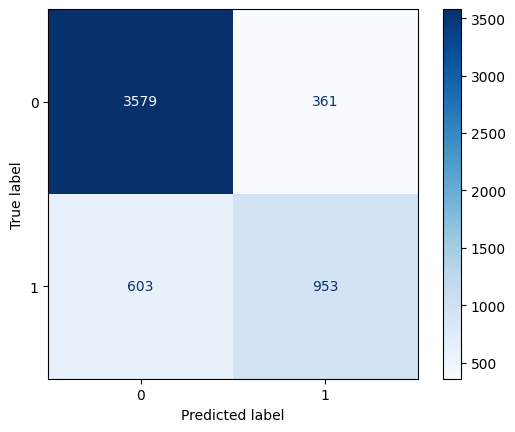

In [42]:
disp.plot(cmap='Blues')
plt.show()

Com base no resultado da matriz de confusão, podemos concluir que o modelo é melhor em prever *tweets* negativos do que *tweets* positivos. Nota-se também um número relativamente alto de FN (603), o que indica uma certa dificuldade do modelo em prever a classe positiva.

In [44]:
tnr = cm[0,0]/(cm[0,0] + cm[0,1])
fpr = cm[0,1]/(cm[0,0] + cm[0,1])
fnr = cm[1,0]/(cm[1,0] + cm[1,1])
tpr = cm[1,1]/(cm[1,0] + cm[1,1])
acc = (cm[0,0] + cm[1,1])/cm.sum()

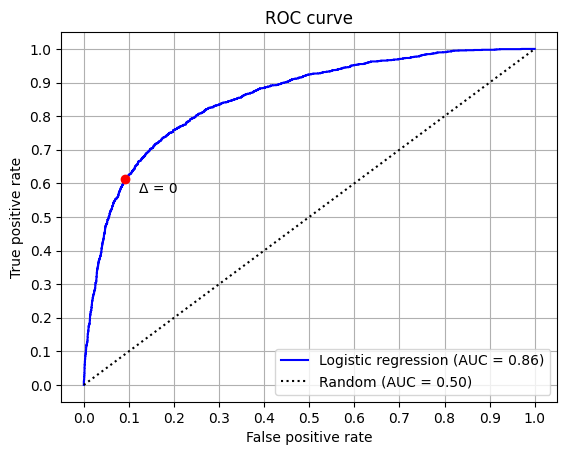

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

fprs, tprs, thresholds = roc_curve(y_test, pipeline_svm.decision_function(X_test))
auc = roc_auc_score(y_test, pipeline_svm.decision_function(X_test))
plt.plot(fprs, tprs, 'b-', label=f'Logistic regression (AUC = {auc:.2f})')
plt.plot(fpr, tpr, 'ro')
plt.annotate('Δ = 0', (fpr+0.03, tpr-0.04))
plt.plot([0, 1], [0, 1], 'k:', label='Random (AUC = 0.50)')
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

## Floresta aleatória

In [48]:
pipeline_rf = Pipeline([
    ("preprocessing", CountVectorizer()),
    ("classifier", RandomForestClassifier(n_estimators=1000, min_samples_split=2)),
])

In [49]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', CountVectorizer()),
                ('classifier', RandomForestClassifier(n_estimators=1000))])

### 10 palavras mais importantes

In [50]:
feature_names = pipeline_rf.named_steps["preprocessing"].get_feature_names_out()
importances = pipeline_rf.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(10):
    print(f"{i + 1}. {feature_names[indices[i]]} ({importances[indices[i]]:.2f})")

1. miss (0.02)
2. sad (0.01)
3. sorry (0.01)
4. hate (0.01)
5. sucks (0.01)
6. bad (0.01)
7. not (0.01)
8. sick (0.01)
9. my (0.01)
10. to (0.01)


### 5 casos de predições erradas

In [73]:
pred = pipeline_rf.predict(X_test)

In [74]:
df = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': pred,
})

In [75]:
incorrect_predictions = df[df['true_label'] != df['predicted_label']]

In [77]:
pd.set_option('display.max_colwidth', None)

In [78]:
incorrect_predictions.head(5)

text  \
12155                                                                                          There go my big plans... thanks, tonsils.   
10064                                                                                        Now I want ice cream but it`s so expensive.   
17875                                                 Why am I so tired?????? Whyyyyy make it stop. Merm is not going to be fun tonight.   
19982                                                                                          And it stopped raining.  Fuckingtastic! )   
13532  sitting in katies house with jo, the other two are away doing stuff, and i have swine flu  and bronchitis but thats a diff story.   

       true_label  predicted_label  
12155           1                0  
10064           1                0  
17875           1                0  
19982           1                0  
13532           1                0

In [79]:
pd.reset_option('display.max_colwidth')

# Conclusão

Aprendi bastante de modo geral nesse trabalho. Consultei bastante documentação, então posso dizer com confiança que tenho certo domínio para discorrer sobre os modelos aqui trabalhados (não digo de cabeça, mas pelo menos sei onde consultar caso haja qualquer dúvida). Achei o trabalho de modo geral bem mais interessante que o primeiro.

Em relação às limitações, é bem óbvio que a limitação computacional é a mais significativa. No meu caso, eu até cheguei a instanciar uma máquina *c7i.24xlarge* na AWS (96 CPUs) mas ainda assim o resultado não ficou pronto no intervalo de uma hora (o que me custou aproximadamente R$25). Deixo em anexo na próxima célula o arquivo que eu usei caso haja interesse.

```python
"""Train a Decision Tree model, a Gradient Boosting model and a Random Forest using Grid Search with hold-out validation."""  # noqa: E501

import os

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

balanced_accuracy = make_scorer(balanced_accuracy_score)

df = pd.read_csv("datasets/Tweets.csv")

df["target"] = df["sentiment"].replace({"neutral": 0, "positive": 0, "negative": 1})
df = df.dropna()
df = df.drop(columns=["textID", "selected_text", "sentiment"])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["text"], df["target"], test_size=0.2, stratify=df["target"], random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  # 25% of 80% is 20% of the total data
    stratify=y_train_val,
    random_state=42,
)

split_index = [-1] * len(X_train) + [0] * len(X_val)
X_train_val_combined = np.concatenate((X_train, X_val))
y_train_val_combined = np.concatenate((y_train, y_val))
ps = PredefinedSplit(test_fold=split_index)

cpus_for_training = os.cpu_count() - 1

print("Using {} CPUs for training".format(cpus_for_training))

pipeline_dt = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", DecisionTreeClassifier()),
    ]
)
param_grid_dt = {
    "classifier__max_depth": list(range(1, 21)),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_leaf_nodes": list(range(2, 51)),
    "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}
param_grid_gb = {
    "classifier__n_estimators": np.linspace(10, 1000, 50, dtype=int),
    "classifier__learning_rate": np.geomspace(3e-3, 1, 20),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_depth": list(range(1, 21)),
}
param_grid_rf = {
    "classifier__n_estimators": 10 ** np.arange(1, 5),
    "classifier__min_samples_split": list(range(2, 6)),
    "classifier__min_samples_leaf": list(range(2, 21)),
    "classifier__max_leaf_nodes": list(range(2, 51)),
    "classifier__min_impurity_decrease": np.geomspace(1e-4, 1e-2, 20),
    "classifier__ccp_alpha": np.geomspace(1e-4, 1.5e-2, 20),
}

grid_search_dt = GridSearchCV(
    pipeline_dt, param_grid_dt, scoring=balanced_accuracy, n_jobs=cpus_for_training, verbose=2, cv=ps
)

pipeline_rf = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", RandomForestClassifier()),
    ]
)
grid_search_rf = GridSearchCV(
    pipeline_rf, param_grid_rf, scoring=balanced_accuracy, n_jobs=cpus_for_training, verbose=2, cv=ps
)
pipeline_gb = Pipeline(
    [
        ("preprocessing", CountVectorizer()),
        ("classifier", GradientBoostingClassifier()),
    ]
)
grid_search_gb = GridSearchCV(
    pipeline_gb, param_grid_gb, scoring=balanced_accuracy, n_jobs=cpus_for_training, verbose=2, cv=ps
)

grid_search_dict = {
    "Random Forest": grid_search_rf,
    "Gradient Boosting": grid_search_gb,
    "Decision Tree": grid_search_dt,
}

for model_name, grid_search in grid_search_dict.items():
    print(f"Start training the {model_name} model.")
    grid_search.fit(X_train_val_combined, y_train_val_combined)

for model_name, grid_search in grid_search_dict.items():
    print(f"Best params ({model_name}):", grid_search.best_params_)
    print(f"Best score ({model_name}):", grid_search.best_score_)
```